In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix

In [73]:
train = pd.read_csv('../data/new_train.csv')
test = pd.read_csv('../data/new_test.csv')
mcf = pd.read_csv('../data/monthly_card_features.csv')

In [74]:
train = train.drop(columns=['Unnamed: 0', 'first_active_month']).set_index('card_id')
test = test.drop(columns=['Unnamed: 0', 'first_active_month']).set_index('card_id')

In [75]:
train = train.join(mcf.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))
test = test.join(mcf.groupby('card_id').agg({
    'amt_total': [np.min, np.mean, np.max],
    'NDR':       [np.min, np.mean, np.max],
    'n_new_merchants':   np.mean,
    'n_total_merchants': np.max
}))

/Users/michaelfedell/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:522: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [76]:
train.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in train.columns.values]
test.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in test.columns.values]

In [77]:
train['chump'] = train['target'] < -20

In [78]:
train.columns

Index(['feature_1', 'feature_2', 'feature_3', 'target', 'tof', 'recency',
       'frequency', 'log_freq', 'amt', 'avg_amt', 'charge_per_day',
       'log_charge_per_day', 'max_amt', 'n_declines', 'log_n_declines',
       'prop_new', 'merch_cat_1_Y', 'merch_cat_2_1', 'merch_cat_2_2',
       'merch_cat_2_3', 'merch_cat_2_4', 'merch_cat_2_5', 'amt_total_amin',
       'amt_total_mean', 'amt_total_amax', 'NDR_amin', 'NDR_mean', 'NDR_amax',
       'n_new_merchants_mean', 'n_total_merchants_amax', 'chump'],
      dtype='object')

In [141]:
balanced = pd.concat([
    train[train.chump],
    train[~train.chump].sample(n=9 * len(train[train.chump]))
])
balanced.chump.describe()

count     22070
unique        2
top       False
freq      19863
Name: chump, dtype: object

In [176]:
# Train on balanced data (10% chumps)
X = balanced.drop(columns=['chump', 'target'])
Y = balanced['chump']

# Train on original, imbalanced data (1% chumps)
# X = train.drop(columns=['chump', 'target'])
# Y = train['chump']

In [177]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.3)
X_train.shape

(15449, 29)

In [178]:
X_val.shape

(6621, 29)

In [179]:
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_val)
print("Accuracy:", accuracy_score(Y_val, Y_pred))

Accuracy: 0.9092282132608367


In [180]:
accuracy_score(train['chump'], clf.predict(train.drop(columns=['chump', 'target'])))

0.9884110798001159

In [181]:
1 - sum(train['target'] < -20) / len(train)

0.9890697662901093

In [182]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp

recency                   0.157624
merch_cat_1_Y             0.057438
tof                       0.056300
prop_new                  0.048282
NDR_mean                  0.043043
amt_total_amin            0.040847
log_charge_per_day        0.039492
amt                       0.038958
charge_per_day            0.038956
max_amt                   0.038836
amt_total_amax            0.038421
n_new_merchants_mean      0.037446
amt_total_mean            0.037395
avg_amt                   0.036986
n_declines                0.033483
n_total_merchants_amax    0.033294
merch_cat_2_1             0.032146
log_n_declines            0.031892
frequency                 0.030683
log_freq                  0.029804
NDR_amin                  0.022713
merch_cat_2_5             0.014350
merch_cat_2_3             0.013241
feature_1                 0.012151
feature_2                 0.011512
merch_cat_2_4             0.010613
merch_cat_2_2             0.009006
feature_3                 0.005087
NDR_amax            

In [198]:
confusion_matrix(Y_val, Y_pred)

array([[5892,   52],
       [ 549,  128]])

No handles with labels found to put in legend.


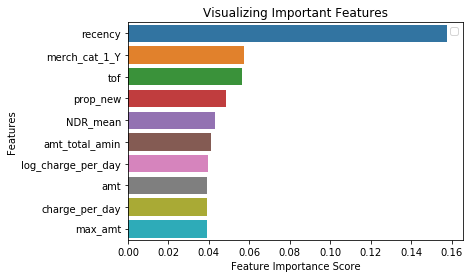

In [195]:
sns.barplot(x=feature_imp.head(10), y=feature_imp.index[:10])
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [1]:
train

NameError: name 'train' is not defined